In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import lime
import lime.lime_tabular

/tmp/ipykernel_3458781/1979477410.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#data importation
import pandas as pd
import numpy as np

# Read the cleaned CSV file
fraud_data = pd.read_csv('CleanedFraudData.csv')

# Display the first few rows
fraud_data.head()


,Unnamed: 0,fraud_bool,income,name_email_similarity,salary,prev_address_months_count,current_address_months_count,customer_age,date_of_birth,days_since_request,...,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,email_domain
0,2,0.0,0.8,0.996707,122830.0,9.0,14.0,40.0,1982-01-01,0.012316,...,200.0,0.0,INTERNET,22.730559,windows,0.0,1.0,0.0,January,aol.com
1,3,0.0,0.6,0.475100,83960.0,11.0,14.0,30.0,1990-09-05,0.006991,...,200.0,0.0,INTERNET,15.215816,linux,1.0,1.0,0.0,January,aol.com
2,6,0.0,0.2,0.773085,38585.0,22.0,4.0,40.0,1984-04-22,0.006919,...,200.0,0.0,INTERNET,28.199923,x11,1.0,1.0,0.0,January,zoho.com
3,8,0.0,0.3,0.523655,40031.0,21.0,2.0,30.0,1992-11-08,0.035206,...,200.0,0.0,INTERNET,5.329387,other,1.0,1.0,0.0,January,business.org
4,18,0.0,0.2,0.527751,37010.0,13.0,114.0,20.0,1999-09-25,0.003171,...,200.0,0.0,INTERNET,2.838194,windows,1.0,2.0,0.0,January,consulting.co


In [3]:
#shape of data
fraud_data.shape

(244191, 36)

In [4]:
# Data Types
fraud_data.dtypes

Unnamed: 0                            int64
fraud_bool                          float64
income                              float64
name_email_similarity               float64
salary                              float64
prev_address_months_count           float64
current_address_months_count        float64
customer_age                        float64
date_of_birth                        object
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                         object
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                float64
date_of_birth_distinct_emails_4w    float64
employment_status                    object
credit_risk_score                   float64
email_is_free                       float64
housing_status                       object
phone_home_valid                

In [5]:
# Removal of some redundant columns
fraud_data = fraud_data.drop(['name_email_similarity','salary','date_of_birth',
                              'zip_count_4w','income','Unnamed: 0'], axis=1)


In [6]:
# create cross tab for actual data
fraud_prop = pd.crosstab(index = fraud_data['fraud_bool'], columns = "prop")/pd.crosstab(index = fraud_data['fraud_bool'], columns = "prop").sum()
print(fraud_prop )

col_0         prop
fraud_bool        
0.0         0.9969
1.0         0.0031


In [7]:
pd.crosstab(index = fraud_data['fraud_bool'], columns = "count")

col_0,count
fraud_bool,
0.0,243434
1.0,757


## Creating Train and Test data

In [8]:
train = fraud_data.groupby("fraud_bool").sample(n = 500, random_state = 1234)
test = fraud_data.loc[fraud_data.index.difference(train.index)]
train.head()

,fraud_bool,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,velocity_6h,velocity_24h,velocity_4w,...,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,email_domain
156658,0.0,30.0,292.0,20.0,8.530328,31.862383,AA,10342.0,5998.0,5180.0,...,200.0,0.0,INTERNET,8.406942,other,0.0,1.0,0.0,May,yandex.com
63213,0.0,52.0,17.0,40.0,0.004717,-0.892632,AD,9698.0,4916.0,5617.0,...,200.0,0.0,INTERNET,3.214909,other,0.0,1.0,0.0,March,gmail.com
196385,0.0,20.0,0.0,30.0,1.221956,-0.683191,AB,3169.0,3642.0,4295.0,...,200.0,0.0,INTERNET,6.651120,other,1.0,1.0,0.0,July,yandex.com
97557,0.0,52.0,16.0,50.0,0.007483,-0.443474,AC,8974.0,5464.0,5191.0,...,1000.0,0.0,INTERNET,5.246280,linux,1.0,1.0,0.0,March,consulting.co
181264,0.0,24.0,4.0,20.0,0.030740,-1.001902,AC,7054.0,3243.0,4373.0,...,200.0,0.0,INTERNET,13.476022,other,0.0,1.0,0.0,June,finance.pro


In [9]:
pd.crosstab(index = train['fraud_bool'], columns = "count")


col_0,count
fraud_bool,
0.0,500
1.0,500


In [10]:
pd.crosstab(index = test['fraud_bool'], columns = "count")

col_0,count
fraud_bool,
0.0,242934
1.0,257


In [11]:
# filling in number dtypes with median and flagging with missing 
train_o = train.copy()
num_cols = train_o.select_dtypes(include='number').columns

for col in num_cols:
    if train_o[col].isnull().any():
        # Create missing flag column
        train_o[f'{col}_was_missing'] = train_o[col].isnull().astype(int)

        # Impute with median
        median = train_o[col].median()
        train_o[col] = train_o[col].fillna(median)
print(train_o.columns)

Index(['fraud_bool', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'payment_type', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month',
       'email_domain'],
      dtype='object')


In [12]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(train_o.dtypes)


fraud_bool                          float64
prev_address_months_count           float64
current_address_months_count        float64
customer_age                        float64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                float64
date_of_birth_distinct_emails_4w    float64
employment_status                    object
credit_risk_score                   float64
email_is_free                       float64
housing_status                       object
phone_home_valid                    float64
phone_mobile_valid                  float64
bank_months_count                   float64
has_other_cards                     float64
proposed_credit_limit               float64
foreign_request                     float64
source                          

In [13]:
# creating X and Y and creating dummies for categorical data 
predictors = train_o.drop(columns=['fraud_bool'])
predictors = pd.get_dummies(predictors, drop_first=True)
predictors = predictors.astype(float)

X = predictors
y = train_o['fraud_bool']

In [14]:
# using Pearson's square to sort data and determine association, 
# Use p-value of 0.002 depending on the data siize
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Separate categorical (dummy) vs. continuous features
categorical_features = [col for col in X.columns if X[col].nunique() == 2]
continuous_features = [col for col in X.columns if X[col].nunique() > 2]

X_cat = X[categorical_features]
X_cont = X[continuous_features]

# Fit SelectKBest for Categorical Variables
selector = SelectKBest(score_func=chi2, k='all')  # 'all' keeps all features for scoring
selector.fit(X_cat, y)

# Create a DataFrame with feature names, Chi2-scores, and p-values
scores_cat_df = pd.DataFrame({
    'Feature': X_cat.columns,
    'Chi2_score': selector.scores_,
    'p_value': selector.pvalues_
})

# Filter for features with p-value < 0.002
selected_cat_features = scores_cat_df[scores_cat_df['p_value'] < 0.002]['Feature']

# Fit SelectKBest for Continous Variables
selector = SelectKBest(score_func=f_classif, k='all')  # 'all' keeps all features for scoring
selector.fit(X_cont, y)

# Create a DataFrame with feature names, F-scores, and p-values
scores_cont_df = pd.DataFrame({
    'Feature': X_cont.columns,
    'F_score': selector.scores_,
    'p_value': selector.pvalues_
})

# Filter for features with p-value < 0.002
selected_cont_features = scores_cont_df[scores_cont_df['p_value'] < 0.002]['Feature']

# Create a new DataFrame with only those selected columns
X_reduced = X[selected_cat_features.tolist() + selected_cont_features.tolist()]

X_reduced.head()

,phone_home_valid,has_other_cards,foreign_request,keep_alive_session,payment_type_AC,employment_status_CB,employment_status_CF,housing_status_BB,device_os_other,device_os_windows,month_August,prev_address_months_count,current_address_months_count,customer_age,intended_balcon_amount,date_of_birth_distinct_emails_4w,credit_risk_score,proposed_credit_limit,device_distinct_emails_8w
156658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,30.0,292.0,20.0,31.862383,9.0,91.0,200.0,1.0
63213,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,52.0,17.0,40.0,-0.892632,12.0,122.0,200.0,1.0
196385,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,20.0,0.0,30.0,-0.683191,16.0,253.0,200.0,1.0
97557,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,52.0,16.0,50.0,-0.443474,4.0,223.0,1000.0,1.0
181264,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,24.0,4.0,20.0,-1.001902,6.0,189.0,200.0,1.0


In [15]:
#remove variables with quasi separation 
def check_quasi_complete_separation(X, y):
    """
    Checks each categorical predictor in X for quasi-complete separation with respect to binary target y.
    
    Parameters:
    - X: pd.DataFrame of predictors (categorical variables)
    - y: pd.Series of binary target variable (e.g., 0/1 or True/False)
    
    Returns:
    - List of variable names that exhibit quasi-complete separation
    """
    problematic_vars = []

    for col in X.columns:
        ct = pd.crosstab(X[col], y)

        # Check if any category (row) has a zero in any outcome class
        if (ct == 0).any(axis=1).any():
            print(f"⚠️ Quasi-complete separation detected in '{col}'")
            print(ct)
            print()
            problematic_vars.append(col)

    return problematic_vars

In [16]:
# Create a new DataFrame with only those selected columns
X_cat_reduced = X_reduced[selected_cat_features]

problem_vars = check_quasi_complete_separation(X_cat_reduced, y)

In [17]:
X_reduced = X_reduced.drop(problem_vars, axis = 1)

## Lasso Regression 

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
import pandas as pd
import numpy as np

# --- Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)  # X_reduced must match feature_names

# --- Logistic LASSO with Cross-Validation ---
lasso_clf = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty='l1',
    solver='saga',
    scoring='roc_auc',
    max_iter=10000,
    n_jobs=-1,
    refit=True,
    random_state=1234
)

lasso_clf.fit(X_scaled, y)
feature_names = X_reduced.columns

# --- Coefficient table ---
lasso_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_clf.coef_.flatten()
})

# Sort by absolute coefficient magnitude
lasso_df['Abs_Coefficient'] = np.abs(lasso_df['Coefficient'])
lasso_df = lasso_df.sort_values(by='Abs_Coefficient', ascending=False)

lasso_df['Model'] = "Logistic Lasso CV"

print("Logistic Lasso CV - Top 10 coefficients")
print(lasso_df.head(10))


Logistic Lasso CV - Top 10 coefficients
                         Feature  Coefficient  Abs_Coefficient  \
3             keep_alive_session    -0.564925         0.564925   
9              device_os_windows     0.511026         0.511026   
0               phone_home_valid    -0.491831         0.491831   
18     device_distinct_emails_8w     0.481115         0.481115   
13                  customer_age     0.397585         0.397585   
1                has_other_cards    -0.339114         0.339114   
14        intended_balcon_amount    -0.308769         0.308769   
7              housing_status_BB    -0.300792         0.300792   
4                payment_type_AC     0.254135         0.254135   
12  current_address_months_count     0.246099         0.246099   

                Model  
3   Logistic Lasso CV  
9   Logistic Lasso CV  
0   Logistic Lasso CV  
18  Logistic Lasso CV  
13  Logistic Lasso CV  
1   Logistic Lasso CV  
14  Logistic Lasso CV  
7   Logistic Lasso CV  
4   Logistic Lass

## Ridge Logistic

In [19]:
Cs = np.logspace(-2, 2, 6)  # fewer, smoother values
ridge_clf = LogisticRegressionCV(
    Cs=Cs,
    cv=5,
    penalty='l2',
    solver='lbfgs',  # lbfgs works well for L2
    scoring='roc_auc',
    max_iter=10000,
    n_jobs=-1,
    refit=True,
    random_state=1234
)
ridge_clf.fit(X_scaled, y)
feature_names = X_reduced.columns

ridge_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': ridge_clf.coef_.flatten()
}).sort_values(by='Coefficient', key=abs, ascending=False)
ridge_df['Model'] = "Logistic Ridge CV"

print("Logistic Ridge CV - Top 10 coefficients")
print(ridge_df.head(10))



Logistic Ridge CV - Top 10 coefficients
                      Feature  Coefficient              Model
3          keep_alive_session    -0.351597  Logistic Ridge CV
9           device_os_windows     0.333296  Logistic Ridge CV
0            phone_home_valid    -0.275125  Logistic Ridge CV
18  device_distinct_emails_8w     0.270651  Logistic Ridge CV
13               customer_age     0.223546  Logistic Ridge CV
1             has_other_cards    -0.214741  Logistic Ridge CV
14     intended_balcon_amount    -0.200837  Logistic Ridge CV
7           housing_status_BB    -0.181868  Logistic Ridge CV
8             device_os_other    -0.174208  Logistic Ridge CV
17      proposed_credit_limit     0.168356  Logistic Ridge CV


## Elastic Logistic combining L1 and L2 

In [20]:

elastic_clf = LogisticRegressionCV(
    Cs=Cs,
    cv=5,
    penalty='elasticnet',
    solver='saga',      # saga supports elasticnet
    l1_ratios=[0.5],    # mix of L1 and L2
    scoring='roc_auc',
    max_iter=10000,
    n_jobs=-1,
    refit=True,
    random_state=42
)
elastic_clf.fit(X_scaled, y)

elastic_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': elastic_clf.coef_.flatten()
}).sort_values(by='Coefficient', key=abs, ascending=False)
elastic_df['Model'] = "Logistic Elastic Net CV"

print("Logistic Elastic Net CV - Top 10 coefficients")
print(elastic_df.head(10))

Logistic Elastic Net CV - Top 10 coefficients
                         Feature  Coefficient                    Model
3             keep_alive_session    -0.551136  Logistic Elastic Net CV
9              device_os_windows     0.501391  Logistic Elastic Net CV
0               phone_home_valid    -0.474656  Logistic Elastic Net CV
18     device_distinct_emails_8w     0.463423  Logistic Elastic Net CV
13                  customer_age     0.384114  Logistic Elastic Net CV
1                has_other_cards    -0.328885  Logistic Elastic Net CV
14        intended_balcon_amount    -0.300180  Logistic Elastic Net CV
7              housing_status_BB    -0.289793  Logistic Elastic Net CV
4                payment_type_AC     0.245023  Logistic Elastic Net CV
12  current_address_months_count     0.234290  Logistic Elastic Net CV


## The above models were done without taking into account the weight 

In [21]:
#Based on Undersampling
weight_1 = 1
weight_0 = (243434/757) / (500/500)

## Lasso with weight 

In [22]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

# Prepare sample weights 
sample_weights = train_o['fraud_bool'].replace({1: weight_1, 0: weight_0}).values
Cs = np.logspace(-2, 2, 6)  

# --- Lasso Logistic Regression (L1) with Cross-Validation and sample weights ---
lasso_clf_w = LogisticRegressionCV(
    Cs=Cs,                     # number of inverse regularization strengths
    cv=5,                      # 5-fold CV
    penalty='l1',              # Lasso
    solver='saga',             # saga supports L1 penalty with logistic regression
    scoring='roc_auc',         # use AUC for scoring
    max_iter=50000,
    tol=1e-3, 
    n_jobs=-1,
    refit=True,
    random_state=1234
)

# --- Fit the weighted model ---
lasso_clf_w.fit(X_scaled, y, sample_weight=sample_weights)

# --- Coefficient table ---
lasso_df_w = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_clf_w.coef_.flatten()
}).sort_values(by='Coefficient', key=abs, ascending=False)

lasso_df_w['Model'] = "Logistic Lasso Weighted CV"

print("Logistic Lasso Weighted CV - Top 10 coefficients")
print(lasso_df_w.head(10))



/home/appij25/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/appij25/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/appij25/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/appij25/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/appij25/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/appij25/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag

Logistic Lasso Weighted CV - Top 10 coefficients
                         Feature  Coefficient                       Model
14        intended_balcon_amount   -67.053652  Logistic Lasso Weighted CV
1                has_other_cards   -59.380014  Logistic Lasso Weighted CV
0               phone_home_valid   -46.609428  Logistic Lasso Weighted CV
5           employment_status_CB   -44.184645  Logistic Lasso Weighted CV
12  current_address_months_count   -38.716344  Logistic Lasso Weighted CV
2                foreign_request   -35.268822  Logistic Lasso Weighted CV
7              housing_status_BB   -32.696723  Logistic Lasso Weighted CV
18     device_distinct_emails_8w    22.618668  Logistic Lasso Weighted CV
11     prev_address_months_count    21.988066  Logistic Lasso Weighted CV
16             credit_risk_score   -21.167979  Logistic Lasso Weighted CV


/home/appij25/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Ridge with weight 

In [23]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)  # X_selected is NumPy array

# --- Prepare sample weights ---
sample_weights = train_o['fraud_bool'].replace({1: weight_1, 0: weight_0}).values

# --- Ridge Logistic Regression (L2) with CV and sample weights ---
ridge_clf_w = LogisticRegressionCV(
    Cs=Cs,
    cv=5,
    penalty='l2',           # Ridge
    solver='lbfgs',          # saga supports L2
    scoring='roc_auc',      # optimize AUC
    max_iter=10000,
    n_jobs=-1,
    refit=True,
    random_state=1234
)

# --- Fit the weighted model ---
ridge_clf_w.fit(X_scaled, y, sample_weight=sample_weights)

# --- Coefficient table ---
ridge_df_w = pd.DataFrame({
    'Feature': feature_names,                
    'Coefficient': ridge_clf_w.coef_.flatten()
}).sort_values(by='Coefficient', key=abs, ascending=False)

ridge_df_w['Model'] = "Logistic Ridge Weighted CV"

print("Logistic Ridge Weighted CV - Top 10 coefficients")
print(ridge_df_w.head(10))


Logistic Ridge Weighted CV - Top 10 coefficients
                      Feature  Coefficient                       Model
18  device_distinct_emails_8w     0.598779  Logistic Ridge Weighted CV
0            phone_home_valid    -0.544021  Logistic Ridge Weighted CV
3          keep_alive_session    -0.538789  Logistic Ridge Weighted CV
13               customer_age     0.416054  Logistic Ridge Weighted CV
9           device_os_windows     0.396362  Logistic Ridge Weighted CV
8             device_os_other    -0.352948  Logistic Ridge Weighted CV
1             has_other_cards    -0.348106  Logistic Ridge Weighted CV
7           housing_status_BB    -0.316645  Logistic Ridge Weighted CV
14     intended_balcon_amount    -0.269424  Logistic Ridge Weighted CV
16          credit_risk_score     0.254566  Logistic Ridge Weighted CV


## Elastic with weight 

In [24]:
# --- Standardize features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

# --- Prepare sample weights ---
sample_weights = train_o['fraud_bool'].replace({1: weight_1, 0: weight_0}).values
Cs = np.logspace(-3, 1, 6)

# --- Elastic Net Logistic Regression with CV ---
elastic_clf_w = LogisticRegressionCV(
    Cs=Cs,                     # e.g., np.logspace(-2, 2, 6)
    cv=5,
    penalty='elasticnet',      # Elastic Net = L1 + L2
    solver='saga',             # required for elasticnet
    l1_ratios=[0.1, 0.2], # mix of L1 and L2
    scoring='roc_auc',
    max_iter=50000,
    tol=1e-2,
    n_jobs=-1,
    refit=True,
    random_state=1234
)

# --- Fit the weighted model ---
elastic_clf_w.fit(X_scaled, y, sample_weight=sample_weights)

# --- Coefficient table ---
elastic_df_w = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': elastic_clf_w.coef_.flatten()
})

# Sort by absolute coefficient magnitude
elastic_df_w['Abs_Coefficient'] = np.abs(elastic_df_w['Coefficient'])
elastic_df_w = elastic_df_w.sort_values(by='Abs_Coefficient', ascending=False)

elastic_df_w['Model'] = "Logistic ElasticNet Weighted CV"

print("Logistic ElasticNet Weighted CV - Top 10 coefficients")
print(elastic_df_w.head(10))


/home/appij25/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/appij25/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/appij25/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/appij25/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/appij25/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/appij25/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag

Logistic ElasticNet Weighted CV - Top 10 coefficients
                      Feature  Coefficient  Abs_Coefficient  \
9           device_os_windows     7.373640         7.373640   
3          keep_alive_session    -6.500953         6.500953   
17      proposed_credit_limit     5.111829         5.111829   
8             device_os_other    -5.082525         5.082525   
16          credit_risk_score     4.980761         4.980761   
18  device_distinct_emails_8w     4.928021         4.928021   
0            phone_home_valid    -4.626854         4.626854   
13               customer_age     4.544093         4.544093   
1             has_other_cards    -3.908777         3.908777   
14     intended_balcon_amount    -3.906177         3.906177   

                              Model  
9   Logistic ElasticNet Weighted CV  
3   Logistic ElasticNet Weighted CV  
17  Logistic ElasticNet Weighted CV  
8   Logistic ElasticNet Weighted CV  
16  Logistic ElasticNet Weighted CV  
18  Logistic ElasticNet 

In [25]:
from sklearn.metrics import roc_auc_score
import pandas as pd

def compute_auc_somersd(model, X, y, model_name):
    """
    Compute AUC (C-statistic) and Somer's D for a given model.
    """
    # Predicted probabilities for positive class
    y_prob = model.predict_proba(X)[:, 1]
    
    # Compute AUC
    auc = roc_auc_score(y, y_prob)
    
    # Compute Somer’s D
    somers_d = 2 * auc - 1
    
    print(f"\n{model_name} Model Performance:")
    print(f"AUC (C-statistic): {auc:.4f}")
    print(f"Somer's D: {somers_d:.4f}")
    
    return {
        "Model": model_name,
        "AUC": auc,
        "Somer's D": somers_d
    }

# --- Compute for all models (pass the fitted model objects) ---
results = []
results.append(compute_auc_somersd(ridge_clf_w, X_scaled, y, "Ridge"))
results.append(compute_auc_somersd(lasso_clf_w, X_scaled, y, "Lasso"))
results.append(compute_auc_somersd(elastic_clf_w, X_scaled, y, "Elastic Net"))

# --- Display summary table ---
auc_summary = pd.DataFrame(results)
print("\nSummary of AUC and Somer's D:")
print(auc_summary)



Ridge Model Performance:
AUC (C-statistic): 0.8577
Somer's D: 0.7155

Lasso Model Performance:
AUC (C-statistic): 0.6766
Somer's D: 0.3531

Elastic Net Model Performance:
AUC (C-statistic): 0.8522
Somer's D: 0.7043

Summary of AUC and Somer's D:
         Model       AUC  Somer's D
0        Ridge  0.857744   0.715488
1        Lasso  0.676572   0.353144
2  Elastic Net  0.852156   0.704312


In [26]:
import pandas as pd
from sklearn.metrics import roc_curve

def best_threshold(model, X, y, model_name):
    """
    Compute the best cutoff using Youden's Index for a model.
    """
    # Predicted probabilities for positive class
    y_prob = model.predict_proba(X)[:, 1]
    
    # Ensure y is integer
    y_true = y.astype(int)
    
    # Check for constant values
    if len(set(y_true)) < 2:
        raise ValueError(f"{model_name}: y_true has only one class. Need both positive and negative samples.")
    
    # Compute ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    
    # Build Youden's index table
    youden = pd.DataFrame({
        'TPR': tpr,
        'FPR': fpr,
        'Cut-off': thresholds,
        'Youden': tpr - fpr
    }).sort_values(by='Youden', ascending=False).reset_index(drop=True)
    
    # Best cutoff
    best_cutoff = youden.loc[0, 'Cut-off']
    print(f"\n{model_name} Best Threshold (Youden's Index): {best_cutoff:.4f}")
    
    return youden, best_cutoff

# --- Compute best thresholds for all models ---
youden_ridge, cutoff_ridge = best_threshold(ridge_clf_w, X_scaled, y, "Ridge")
youden_lasso, cutoff_lasso = best_threshold(lasso_clf_w, X_scaled, y, "Lasso")
youden_elastic, cutoff_elastic = best_threshold(elastic_clf_w, X_scaled, y, "Elastic Net")

# Optional: show top 5 thresholds for Ridge
youden_ridge.head()



Ridge Best Threshold (Youden's Index): 0.0050

Lasso Best Threshold (Youden's Index): 0.0000

Elastic Net Best Threshold (Youden's Index): 0.0000


,TPR,FPR,Cut-off,Youden
0,0.718,0.134,0.005021,0.584
1,0.714,0.130,0.005214,0.584
2,0.746,0.162,0.004141,0.584
3,0.744,0.160,0.004190,0.584
4,0.748,0.164,0.004014,0.584


In [27]:
import pandas as pd

def compute_confusion_matrix(model, X, y, model_name, cutoff=0.0050):
    """
    Compute confusion matrix using a probability cutoff.
    """
    # Predicted probabilities for positive class
    y_prob = model.predict_proba(X)[:, 1]
    
    # Convert probabilities to binary predictions using cutoff
    y_pred = (y_prob > cutoff).astype(int)
    
    # Confusion matrix as crosstab
    cm = pd.crosstab(y, y_pred, rownames=['Actual'], colnames=['Predicted'])
    
    print(f"\n{model_name} Confusion Matrix (cutoff={cutoff}):")
    print(cm)
    
    return cm

# --- Compute confusion matrices for all models ---
cm_ridge = compute_confusion_matrix(ridge_clf_w, X_scaled, y, "Ridge")
cm_lasso = compute_confusion_matrix(lasso_clf_w, X_scaled, y, "Lasso")
cm_elastic = compute_confusion_matrix(elastic_clf_w, X_scaled, y, "Elastic Net")



Ridge Confusion Matrix (cutoff=0.005):
Predicted    0    1
Actual             
0.0        432   68
1.0        141  359

Lasso Confusion Matrix (cutoff=0.005):
Predicted    0   1
Actual            
0.0        499   1
1.0        481  19

Elastic Net Confusion Matrix (cutoff=0.005):
Predicted    0   1
Actual            
0.0        500   0
1.0        490  10


In [28]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve

def cost_sensitive_threshold(model, X, y, model_name, C_FN=1200, C_FP_values=np.arange(700, 1001, 100)):
    """
    Compute optimal thresholds taking into account business costs.
    """
    # Predicted probabilities
    y_prob = model.predict_proba(X)[:, 1]
    y_true = y.astype(int)
    
    # Check for constant target
    if len(set(y_true)) < 2:
        raise ValueError(f"{model_name}: y_true has only one class. Need both positive and negative samples.")
    
    # Compute ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    
    total_pos = sum(y_true)
    total_neg = len(y_true) - total_pos
    
    # Build results DataFrame
    results = pd.DataFrame({
        'Threshold': thresholds,
        'TPR': tpr,
        'FPR': fpr
    })
    
    # Compute cost for each FP cost level
    for C_FP in C_FP_values:
        results[f'Cost_FP{C_FP}'] = (
            (C_FP * results['FPR'] * total_neg) + 
            (C_FN * (1 - results['TPR']) * total_pos)
        )
    
    # Find best thresholds
    best_thresholds = []
    for C_FP in C_FP_values:
        col = f'Cost_FP{C_FP}'
        idx_min = results[col].idxmin()
        best_thresholds.append({
            'C_FP': C_FP,
            'Best_Threshold': results.loc[idx_min, 'Threshold'],
            'Min_Cost': results.loc[idx_min, col],
            'TPR': results.loc[idx_min, 'TPR'],
            'FPR': results.loc[idx_min, 'FPR']
        })
    
    best_df = pd.DataFrame(best_thresholds)
    print(f" {model_name}: Optimal thresholds by false positive cost")
    print(best_df)
    
    return best_df, results

# --- Compute for all models (use the fitted model objects) ---
best_ridge_df, ridge_results = cost_sensitive_threshold(ridge_clf_w, X_scaled, y, "Ridge")
best_lasso_df, lasso_results = cost_sensitive_threshold(lasso_clf_w, X_scaled, y, "Lasso")
best_elastic_df, elastic_results = cost_sensitive_threshold(elastic_clf_w, X_scaled, y, "Elastic Net")


 Ridge: Optimal thresholds by false positive cost
   C_FP  Best_Threshold  Min_Cost    TPR    FPR
0   700        0.003441  206500.0  0.776  0.206
1   800        0.003668  216400.0  0.762  0.184
2   900        0.004014  225000.0  0.748  0.164
3  1000        0.004014  233200.0  0.748  0.164
 Lasso: Optimal thresholds by false positive cost
   C_FP  Best_Threshold  Min_Cost    TPR    FPR
0   700   1.836043e-150  310500.0  0.906  0.726
1   800   5.264785e-122  345200.0  0.814  0.584
2   900   5.264785e-122  374400.0  0.814  0.584
3  1000    2.632721e-88  400800.0  0.662  0.396
 Elastic Net: Optimal thresholds by false positive cost
   C_FP  Best_Threshold  Min_Cost    TPR    FPR
0   700    5.928183e-32  202500.0  0.848  0.318
1   800    5.928183e-32  218400.0  0.848  0.318
2   900    2.484808e-30  231600.0  0.806  0.256
3  1000    4.460416e-29  242400.0  0.766  0.204


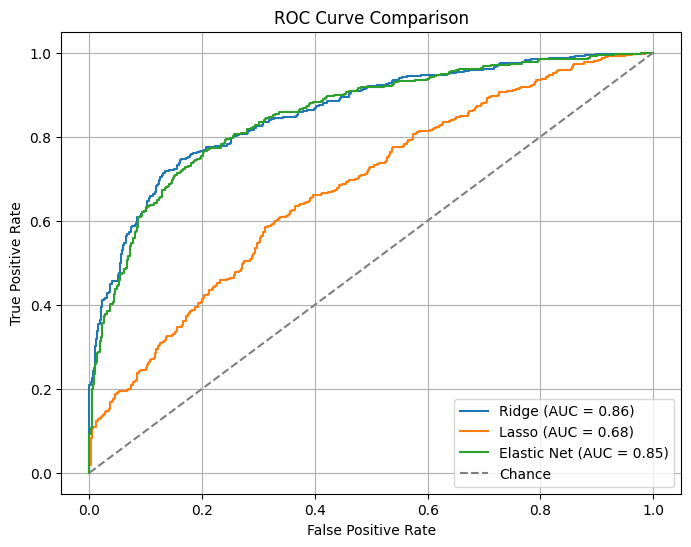

Ridge AUC: 0.8577
Lasso AUC: 0.6766
Elastic Net AUC: 0.8522


In [29]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc(model, X, y, model_name):
    """Plot ROC curve with AUC for a given model."""
    y_prob = model.predict_proba(X)[:, 1]
    y_true = y.astype(int)
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_val = roc_auc_score(y_true, y_prob)
    
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_val:.2f})")
    return fpr, tpr, auc_val

# --- Plot all models together ---
plt.figure(figsize=(8,6))

fpr_ridge, tpr_ridge, auc_ridge = plot_roc(ridge_clf_w, X_scaled, y, "Ridge")
fpr_lasso, tpr_lasso, auc_lasso = plot_roc(lasso_clf_w, X_scaled, y, "Lasso")
fpr_elastic, tpr_elastic, auc_elastic = plot_roc(elastic_clf_w, X_scaled, y, "Elastic Net")

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

# --- Print AUC values ---
print(f"Ridge AUC: {auc_ridge:.4f}")
print(f"Lasso AUC: {auc_lasso:.4f}")
print(f"Elastic Net AUC: {auc_elastic:.4f}")


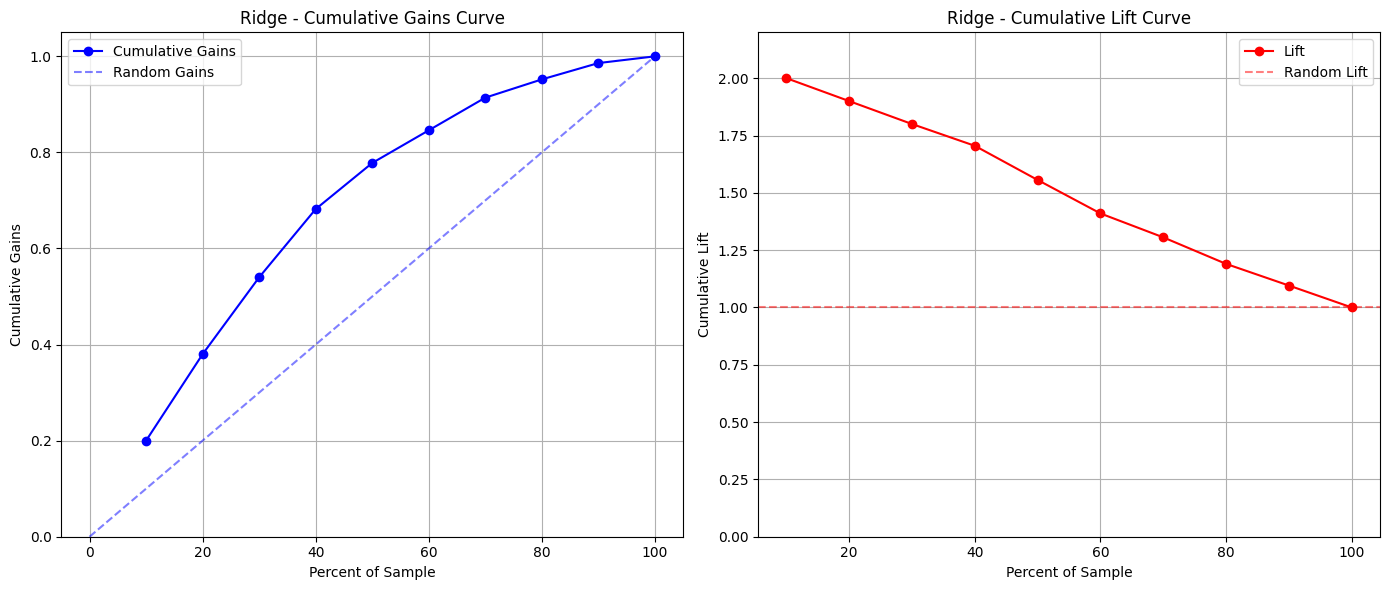

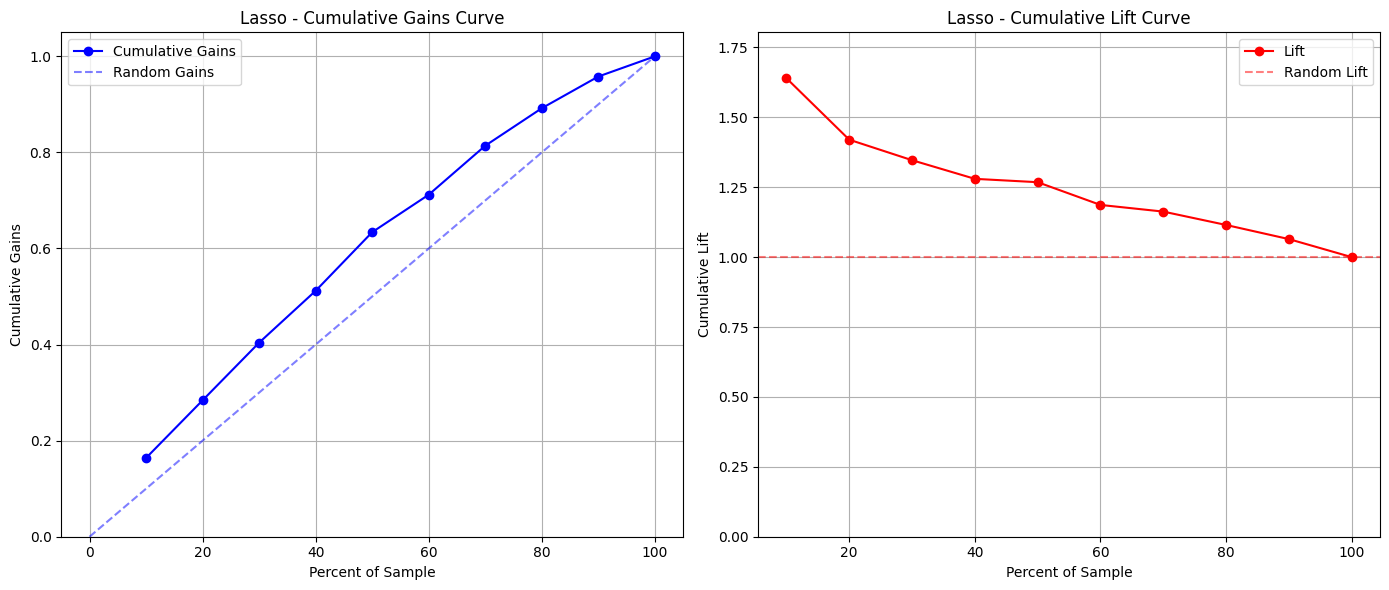

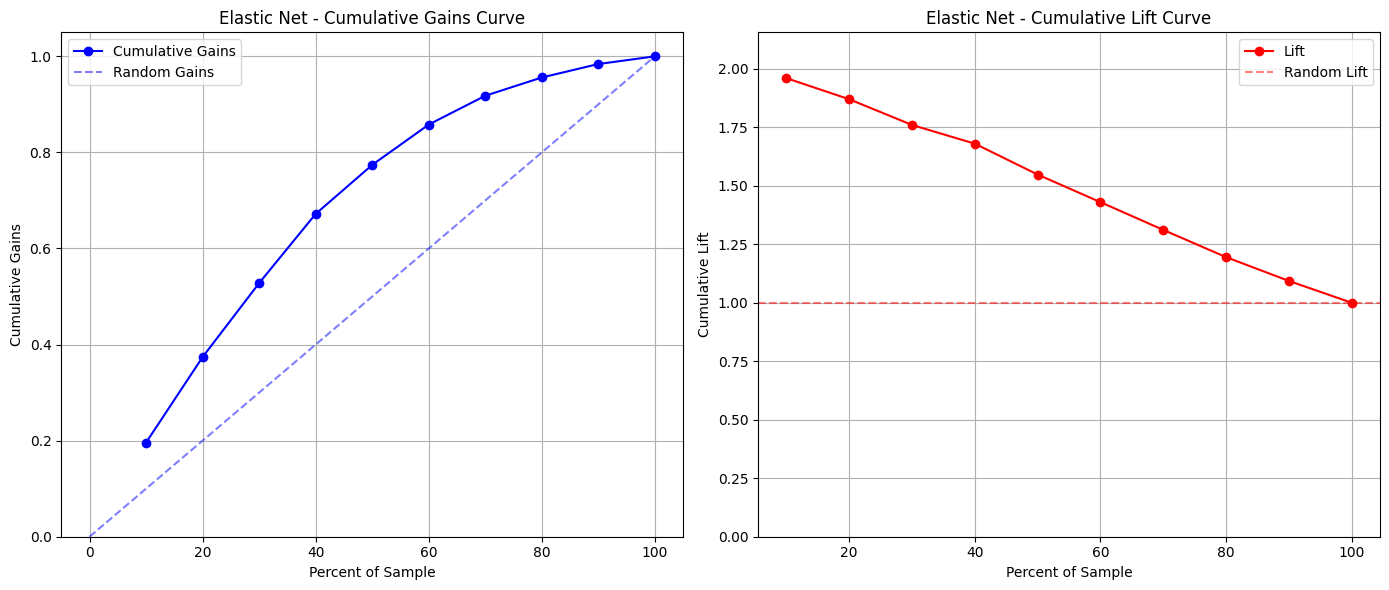

In [30]:
# --- Gains and Lift Plots for Ridge, Lasso, and Elastic Net ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_lift_and_gains_model(model, X, y, model_name, n_bins=10):
    """
    Plot Lift and Cumulative Gains curves for a given model.
    
    Parameters:
    - model: trained model with predict_proba method
    - X: features
    - y: true binary labels
    - model_name: string, model label for title
    - n_bins: number of bins/deciles
    """
    y_true = y.astype(int)
    y_proba = model.predict_proba(X)[:, 1]
    
    df = pd.DataFrame({'y_true': y_true, 'y_proba': y_proba})
    
    # Sort descending by predicted probability
    df = df.sort_values(by='y_proba', ascending=False).reset_index(drop=True)
    
    # Cumulative counts
    df['cum_total'] = np.arange(1, len(df)+1)
    df['cum_positives'] = df['y_true'].cumsum()
    
    total_positives = df['y_true'].sum()
    total_samples = len(df)
    
    # Cumulative Gains and Lift
    df['cum_gains'] = df['cum_positives'] / total_positives
    df['cum_lift'] = df['cum_gains'] / (df['cum_total'] / total_samples)
    
    # Sample points for plotting
    cutoffs = np.linspace(0, total_samples, n_bins+1, dtype=int)
    cutoffs = cutoffs[cutoffs > 0]
    plot_points = df.loc[cutoffs-1, ['cum_total', 'cum_gains', 'cum_lift']].copy()
    plot_points['percent_samples'] = plot_points['cum_total'] / total_samples * 100
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14,6))
    
    # Cumulative Gains
    axes[0].plot(plot_points['percent_samples'], plot_points['cum_gains'], marker='o', color='blue', label='Cumulative Gains')
    axes[0].plot([0,100], [0,1], linestyle='--', color='blue', alpha=0.5, label='Random Gains')
    axes[0].set_xlabel('Percent of Sample')
    axes[0].set_ylabel('Cumulative Gains')
    axes[0].set_title(f'{model_name} - Cumulative Gains Curve')
    axes[0].set_ylim(0,1.05)
    axes[0].grid(True)
    axes[0].legend()
    
    # Cumulative Lift
    axes[1].plot(plot_points['percent_samples'], plot_points['cum_lift'], marker='o', color='red', label='Lift')
    axes[1].axhline(1, linestyle='--', color='red', alpha=0.5, label='Random Lift')
    axes[1].set_xlabel('Percent of Sample')
    axes[1].set_ylabel('Cumulative Lift')
    axes[1].set_title(f'{model_name} - Cumulative Lift Curve')
    axes[1].set_ylim(0, plot_points['cum_lift'].max()*1.1)
    axes[1].grid(True)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# --- Generate Gains and Lift plots for all models ---
plot_lift_and_gains_model(ridge_clf_w, X_scaled, y, "Ridge")
plot_lift_and_gains_model(lasso_clf_w, X_scaled, y, "Lasso")
plot_lift_and_gains_model(elastic_clf_w, X_scaled, y, "Elastic Net")


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

def plot_ks(model, X, y, model_name):
    """
    Plot KS (Kolmogorov-Smirnov) statistic curve for a given model.
    
    Parameters:
    - model: fitted model with predict_proba method
    - X: feature matrix
    - y: true binary labels
    - model_name: string for title/legend
    """
    # Predicted probabilities for positive class
    y_prob = model.predict_proba(X)[:, 1]
    y_true = y.astype(int)
    
    # Compute ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    
    # Build Youden DataFrame
    youden = pd.DataFrame({
        'Cut-off': thresholds,
        'TPR': tpr,
        'FPR': fpr,
        'Youden': tpr - fpr
    }).sort_values(by='Cut-off', ascending=True)
    
    # Prepare data for seaborn lineplot
    ks_stat = youden.rename(columns={'TPR': 'PR_T', 'FPR': 'PR_F'})
    ks_stat = ks_stat.melt(id_vars='Cut-off', var_name='PR', value_name='value')
    
    # KS value and cutoff
    ks_val = youden['TPR'].sub(youden['FPR']).max()
    ks_cutoff = youden.loc[(youden['TPR'] - youden['FPR']).idxmax(), 'Cut-off']
    
    # Plot
    plt.figure(figsize=(8,6))
    sns.lineplot(x='Cut-off', y='value', hue='PR', data=ks_stat)
    plt.xlim(1, 0)
    plt.title(f"KS Plot - {model_name} (KS = {ks_val:.2f})")
    plt.grid(True)
    plt.axvline(x=ks_cutoff, linestyle='--', color='red', label=f'KS cutoff = {ks_cutoff:.4f}')
    plt.legend()
    plt.show()
    
    return ks_val, ks_cutoff


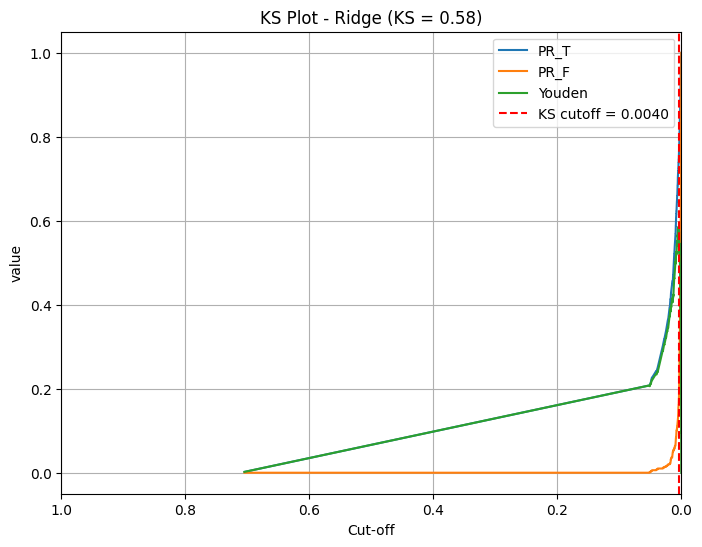

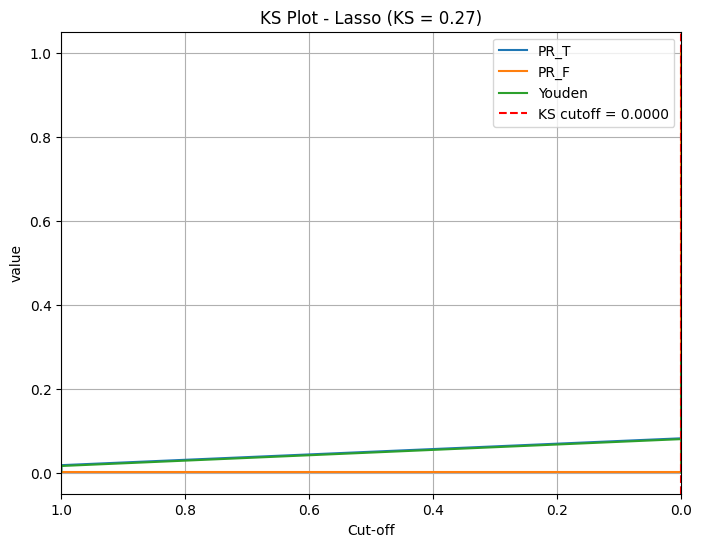

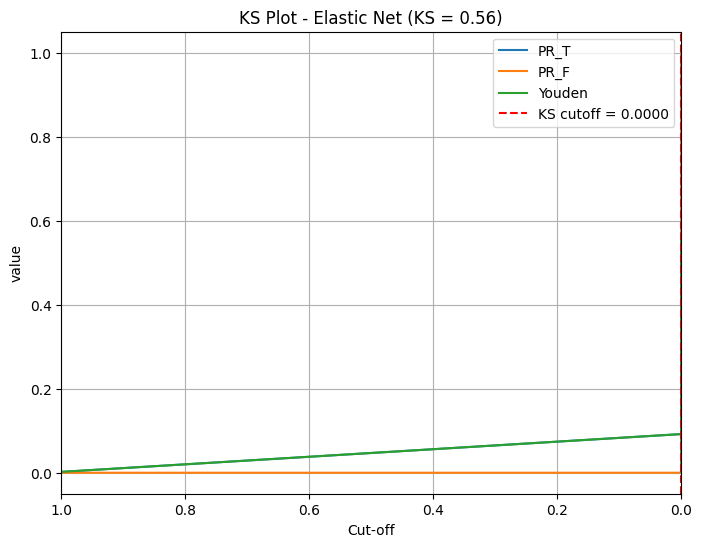

In [32]:
ks_ridge, ks_cutoff_ridge = plot_ks(ridge_clf_w, X_scaled, y, "Ridge")
ks_lasso, ks_cutoff_lasso = plot_ks(lasso_clf_w, X_scaled, y, "Lasso")
ks_elastic, ks_cutoff_elastic = plot_ks(elastic_clf_w, X_scaled, y, "Elastic Net")


## Transforming the test 

In [33]:
test_o= test.copy()
num_cols_test = test_o.select_dtypes(include='number').columns

for col in num_cols_test:
    if test_o[col].isnull().any():
        # Create missing flag column
        test_o[f'{col}_was_missing'] = test_o[col].isnull().astype(int)

        # Impute with median
        median = test_o[col].median()
        test_o[col] = test_o[col].fillna(median)
print(test_o.columns)

Index(['fraud_bool', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'payment_type', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month',
       'email_domain', 'velocity_6h_was_missing'],
      dtype='object')


In [34]:
# --- Step 1: Prepare test predictors ---
predictors_test = test_o.drop(columns=['fraud_bool'])
predictors_test = pd.get_dummies(predictors_test, drop_first=True)
predictors_test = predictors_test.astype(float)

# --- Step 2: Align test features with training features ---
# Use the columns from X_train (before scaling)
train_columns = X_reduced.columns  # or X_selected.columns if you selected features

# Add missing columns in test set
for col in train_columns:
    if col not in predictors_test.columns:
        predictors_test[col] = 0

# Remove extra columns not in training
predictors_test = predictors_test[train_columns]

# Now X_test matches X_train exactly
X_test = predictors_test
y_test = test_o['fraud_bool']

# --- Step 3: Scale using the training scaler ---
X_test_scaled = scaler.transform(X_test)

# Check
X_test_scaled.shape, X_test.head()


((243191, 19),
    phone_home_valid  has_other_cards  foreign_request  keep_alive_session  \
 0               0.0              0.0              0.0                 0.0   
 1               0.0              0.0              0.0                 1.0   
 2               1.0              0.0              0.0                 1.0   
 3               1.0              0.0              0.0                 1.0   
 4               1.0              0.0              0.0                 1.0   
 
    payment_type_AC  employment_status_CB  employment_status_CF  \
 0              0.0                   0.0                   0.0   
 1              0.0                   0.0                   0.0   
 2              0.0                   0.0                   0.0   
 3              0.0                   0.0                   0.0   
 4              0.0                   0.0                   0.0   
 
    housing_status_BB  device_os_other  device_os_windows  month_August  \
 0                0.0              0

In [35]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, recall_score,
    precision_score, f1_score, confusion_matrix, classification_report
)
import pandas as pd

def evaluate_classification(model, X, y, model_name, threshold=0.5):
    """
    Compute classification metrics for a given model and threshold.
    
    Parameters:
    - model: fitted model with predict_proba
    - X: features
    - y: true binary labels
    - model_name: string label for output
    - threshold: probability cutoff for binary prediction
    """
    # Predicted probabilities for positive class
    y_prob = model.predict_proba(X)[:, 1]
    
    # Convert probabilities to binary predictions using threshold
    y_pred = (y_prob >= threshold).astype(int)
    
    # Compute metrics
    accuracy = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_prob)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    
    # Confusion matrix and classification report
    cm = confusion_matrix(y, y_pred)
    report = classification_report(y, y_pred, digits=4)
    
    # Display results
    print(f"\n====== {model_name} CLASSIFICATION PERFORMANCE ======")
    print(f"Threshold: {threshold:.6f}")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    
    print("\nConfusion Matrix:")
    print(cm)
    
    print("\nClassification Report:")
    print(report)
    
    # Return metrics as dictionary for further analysis
    metrics_dict = {
        'Model': model_name,
        'Threshold': threshold,
        'Accuracy': accuracy,
        'ROC-AUC': auc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ConfusionMatrix': cm,
        'ClassificationReport': report
    }
    
    return metrics_dict


In [36]:
# Example: using thresholds from cost-sensitive or Youden's index
metrics_ridge = evaluate_classification(ridge_clf_w, X_test_scaled, y_test, "Ridge", threshold=0.05)
metrics_lasso = evaluate_classification(lasso_clf_w, X_test_scaled, y_test, "Lasso", threshold=0.00)
metrics_elastic = evaluate_classification(elastic_clf_w, X_test_scaled, y_test, "Elastic Net", threshold=0.00)



====== Ridge CLASSIFICATION PERFORMANCE ======
Threshold: 0.050000
Accuracy : 0.9907
ROC-AUC  : 0.8306
Precision: 0.0197
Recall   : 0.1595
F1 Score : 0.0350

Confusion Matrix:
[[240892   2042]
 [   216     41]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9991    0.9916    0.9953    242934
         1.0     0.0197    0.1595    0.0350       257

    accuracy                         0.9907    243191
   macro avg     0.5094    0.5756    0.5152    243191
weighted avg     0.9981    0.9907    0.9943    243191



/home/appij25/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/appij25/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/appij25/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



====== Lasso CLASSIFICATION PERFORMANCE ======
Threshold: 0.000000
Accuracy : 0.0011
ROC-AUC  : 0.6448
Precision: 0.0011
Recall   : 1.0000
F1 Score : 0.0021

Confusion Matrix:
[[     0 242934]
 [     0    257]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000    242934
         1.0     0.0011    1.0000    0.0021       257

    accuracy                         0.0011    243191
   macro avg     0.0005    0.5000    0.0011    243191
weighted avg     0.0000    0.0011    0.0000    243191



/home/appij25/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/appij25/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



====== Elastic Net CLASSIFICATION PERFORMANCE ======
Threshold: 0.000000
Accuracy : 0.0011
ROC-AUC  : 0.8361
Precision: 0.0011
Recall   : 1.0000
F1 Score : 0.0021

Confusion Matrix:
[[     0 242934]
 [     0    257]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000    242934
         1.0     0.0011    1.0000    0.0021       257

    accuracy                         0.0011    243191
   macro avg     0.0005    0.5000    0.0011    243191
weighted avg     0.0000    0.0011    0.0000    243191



/home/appij25/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


<Figure size 1000x600 with 0 Axes>

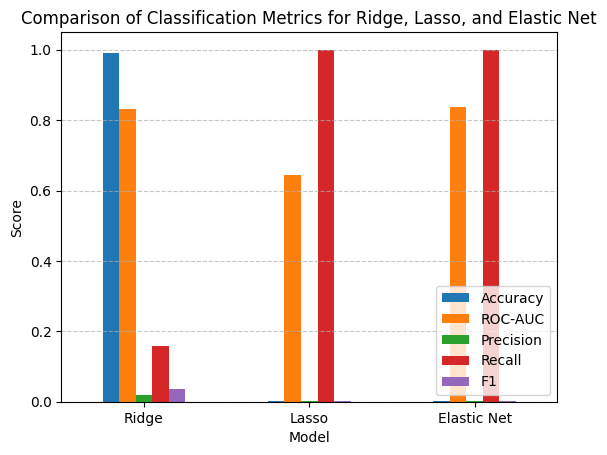

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Collect metrics in a DataFrame ---
metrics_df = pd.DataFrame([
    metrics_ridge,
    metrics_lasso,
    metrics_elastic
])

# Select only numeric metrics for plotting
plot_metrics = metrics_df[['Model', 'Accuracy', 'ROC-AUC', 'Precision', 'Recall', 'F1']]

# Set 'Model' as index
plot_metrics.set_index('Model', inplace=True)

# --- Plot ---
plt.figure(figsize=(10,6))
plot_metrics.plot(kind='bar', rot=0)
plt.title("Comparison of Classification Metrics for Ridge, Lasso, and Elastic Net")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.show()
